In [1]:
using Pkg
Pkg.activate("/Users/ryansenne/Documents/GitHub/ssm_julia")

using Distributions
using ForwardDiff
using LinearAlgebra
using Optim
using Plots
using Random
using SSM

  Activating project at `\Users\ryansenne\Documents\GitHub\ssm_julia`


In [2]:
# Random.seed!(1234)
g = 9.81
l=1
# time differential
dt = 0.01
# transition matrix
A = [1.0 dt; -g/l*dt 1.0]
# Initial state
x0 = [0.0, 1.0]
# Define the LDS model parameters
H = I(2)  # Observation matrix (assuming direct observation)
Q = 0.01 * I(2)  # Process noise covariance
observation_noise_std = 0.5
R = (observation_noise_std^2) * I(2)  # Observation noise covariance
p0 = 0.1*I(2)  # Initial state covariance

lds = SSM.LDS(;A=A, H=H, Q=Q, R=R, x0=x0, p0=p0, obs_dim=2, latent_dim=2)

x, y = SSM.sample(lds, 100)

([-0.17135717028880568 0.43138228473940976; -0.26787105400700506 0.5249280801967313; … ; 0.2504713922090314 -0.21932895632234362; 0.39591025316666495 -0.20610232694138958], [-0.7344744827302201 0.43423438952459437; -0.9068922948855531 1.3347975552334361; … ; -0.1619275128681657 0.42382557943655597; -0.031415515684470374 0.4079794436243817])

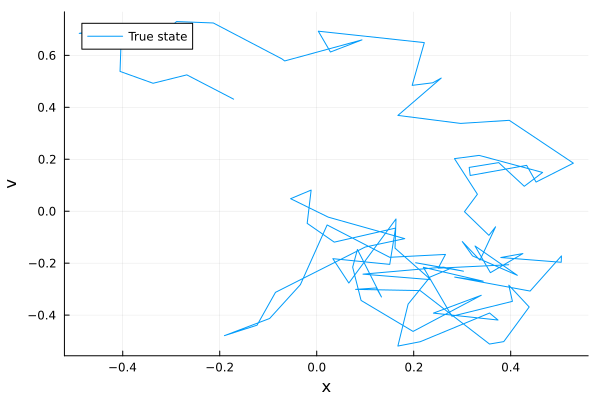

In [3]:
plot(x[:, 1], x[:, 2], label="True state", xlabel="x", ylabel="v", legend=:topleft)

In [4]:
test_lds = SSM.LDS(;obs_dim=2, latent_dim=2, fit_bool=[true, true, true, true, true, true, true])
test_lds.A = [1.0 1.0; 1.0 1.0]
test_lds.H = [0.8 0; 0.0 0.8]
test_lds.Q = [1.0 0.0; 0.0 1.0]
test_lds.R = [1.0 0.0; 0.0 1.0]
test_lds.x0 = [0.0, 0.0]
test_lds.p0 = [1.0 0.0; 0.0 1.0]

2×2 Matrix{Float64}:
 1.0  0.0
 0.0  1.0

In [11]:
_, _, E_z, E_zz, E_zz_prev, ml = SSM.E_Step(test_lds, y, SSM.RTSSmoothing())
_, _, E_z_dir, E_zz_dir, E_zz_prev_dir, ml_dir = SSM.E_Step(test_lds, y, SSM.DirectSmoothing())

([-0.2839695993427618 0.2861322895620255; -0.48365621012995413 0.6098510338305283; … ; -0.0041440616545665495 0.28158915410383434; 0.15384919506200698 0.3681881996029104], [0.40887000062107676 -0.20088609693989845; 0.42686364659759 -0.18289245096338566; … ; 0.5159340043779685 -0.09382209318300683; 0.923640624029567 0.3138845264685915;;; -0.20088609693989828 0.4088700006210769; -0.18289245096338566 0.4268636465975897; … ; -0.0938220931830071 0.5159340043779685; 0.3138845264685915 0.9236406240295669], [-0.2839695993427618 0.2861322895620255; -0.48365621012995413 0.6098510338305283; … ; -0.0041440616545665495 0.28158915410383434; 0.15384919506200698 0.3681881996029104], [0.4895087339719654 -0.28213896856585396; 0.6607869761948604 -0.47785069072969344; … ; 0.5159511776249653 -0.09498901599887036; 0.9473101988507945 0.3705299846088288;;; -0.28213896856585374 0.49074168775108373; -0.47785069072969344 0.7987819300617538; … ; -0.09498901599887064 0.5952264560868815; 0.3705299846088288 1.059203

In [8]:
isapprox(E_zz_prev_dir, E_zz_prev, atol=1e-6)

true

In [9]:
sum((E_zz_prev_dir - E_zz_prev).^2)

3.1546949156181667e-29

In [105]:
E_zz[1, :, :]

2×2 Matrix{Float64}:
 0.373723   0.0974494
 0.0974494  0.458379

In [138]:
obj = p0 -> -SSM.Q(test_lds.A, test_lds.Q, test_lds.H, test_lds.R, p0, test_lds.x0, E_z, E_zz, E_zz_prev, y)
p0 = Optim.minimizer(optimize(obj, test_lds.p0, LBFGS()))

p0 * p0

2×2 Matrix{Float64}:
  0.264081   -0.118658
 -0.0643373   0.152554

In [142]:
function Q_func(A::Matrix{<:Real}, Q::AbstractMatrix{<:Real}, H::Matrix{<:Real}, R::AbstractMatrix{<:Real}, P0::AbstractMatrix{<:Real}, x0::Vector{<:Real}, E_z::Matrix{<:Real}, E_zz::Array{<:Real}, E_zz_prev::Array{<:Real}, y::Matrix{<:Real})
    # Convert Q, R, and P0 to proper matrices
    Q = Q * Q'
    R = R * R'
    P0 = P0 * P0'
    # calculate the inverses
    R_inv = inv(R)
    Q_inv = inv(Q)
    P0_inv = inv(P0)
    # Calculate the Q-function
    Q_val = 0.0
    # Calculate the Q-function for the first time step
    Q_val += -0.5 * (logdet(P0) + tr(P0_inv * (E_zz[1, :, :] - 2*(E_z[1, :] * x0') + (x0 * x0'))))
    # Calculate the Q-function for the state model
    for t in axes(E_z, 1)[2:end] # skip the first time step
        # Individual terms
        term1 = E_zz[t, :, :]
        term2 = A * E_zz_prev[t, :, :]'
        term3 = E_zz_prev[t, :, :] * A'
        term4 = A * E_zz[t-1, :, :] * A'
        # Calculate the Q-value
        q_val = -0.5 * (logdet(Q) + tr(Q_inv * (term1 - term2 - term3 + term4)))
        Q_val += q_val
    end
    # Calculate the Q-function for the observation model
    for t in axes(E_z, 1)
        # Individual terms
        term1 = y[t, :] * y[t, :]'
        term2 = H * (E_z[t, :] * y[t, :]')
        term3 = (y[t, :] * E_z[t, :]') * H'
        term4 = H * E_zz[t, :, :] * H'
        # Calculate the Q-value`
        q_val = -0.5 * (logdet(R) + tr(R_inv * (term1 - term2 - term3 + term4)))
        Q_val += q_val
    end
    return Q_val
end

obj_new = p0 -> -Q_func(test_lds.A, test_lds.Q, test_lds.H, test_lds.R, p0, test_lds.x0, E_z, E_zz, E_zz_prev, y)
p0 = Optim.minimizer(optimize(obj_new, test_lds.p0, LBFGS()))

2×2 Matrix{Float64}:
  0.340039  -0.369789
 -0.369789  -0.0738552

In [143]:
ForwardDiff.gradient(obj_new, p0)

2×2 Matrix{Float64}:
 4.24901e-9   -8.09552e-9
 5.14125e-10  -3.09253e-9

In [141]:
SSM.KalmanFilterEM!(test_lds, y, 1)

1-element Vector{Any}:
 -249.63093976230536

In [128]:
c = Matrix(cholesky(test_lds.p0).L)

2×2 Matrix{Float64}:
  0.560139  0.0
 -0.238745  0.421964

In [100]:
c = Matrix(cholesky(test_lds.p0).L)

2×2 Matrix{Float64}:
  0.502365  0.0
 -0.195937  0.322192

In [23]:
p0 * p0'

2×2 Matrix{Float64}:
  0.413313  -0.175671
 -0.175671   0.551968

In [4]:
function sufficient_statistics(μ::Matrix{<:Real}, P::Array{<:Real}, P_tt1::Array{<:Real})
    # Get dimensions
    T, D = size(μ)
    # Initialize sufficient statistics
    E_z = zeros(T, D)
    E_zz = zeros(T, D, D)
    E_zz_prev = zeros(T, D, D)
    # Compute sufficient statistics
    for t in 1:T
        E_z[t, :] = μ[t, :]
        E_zz[t, :, :] = P[t, :, :] + (μ[t, :] * μ[t, :]')
        if t > 1
            E_zz_prev[t, :, :] = (P_tt1[t-1, :, :]') + (μ[t, :] * μ[t-1, :]')
        end
    end
    return E_z, E_zz, E_zz_prev
end

x_sm, p_sm, ptt1 = SSM.KalmanSmoother(test_lds, y, "Direct")
E_z, E_zz, E_zz_prev = sufficient_statistics(x_sm, p_sm, ptt1)


Norm of gradient iterate difference: 6.0539979027119655
Converged at iteration 2


([-0.2702085619477476 0.7184800031908323; 0.23910713301161973 0.47313456951695826; … ; 0.02770568069692386 0.07838062357897006; 0.16441950767143457 0.06376808186413167], [0.4818826675709465 -0.3950255453903063; 0.4840358676546264 -0.06976260051749889; … ; 0.5167016091208484 -0.0916505046533021; 0.9506743985324839 0.32436924309384374;;; -0.3950255453903062 0.9250835156061753; -0.06976260051749889 0.6507199674695872; … ; -0.09165050465330238 0.5220775265305967; 0.32436924309384374 0.9277069922941975], [0.0 0.0; -0.021351490372056872 -0.08458770744648214; … ; 0.09322302836136458 0.10315574125619945; 0.26194066608413513 0.25915204981902773;;; 0.0 0.0; 0.215050997879601 0.38319503120669896; … ; 0.08405941982922317 0.07723147832832418; 0.27027261524407925 0.2623834937251902])

In [5]:
dropdims(sum(E_zz_prev, dims=1), dims=1) * pinv(dropdims(sum(E_zz[1:end-1, :, :], dims=1), dims=1))

2×2 Matrix{Float64}:
 0.263766  0.239708
 0.366993  0.489321

In [8]:
Q_L = Matrix(cholesky(test_lds.Q).L)
R_L = Matrix(cholesky(test_lds.R).L)
P0_L = Matrix(cholesky(test_lds.p0).L)
# SSM.Q(test_lds.A, Q_L, test_lds.H, R_L, P0_L, test_lds.x0, E_z, E_zz, E_zz_prev, y)
function Q_fun(A::Matrix{<:Real}, Q::Matrix{<:Real}, H::Matrix{<:Real}, R::Matrix{<:Real}, P0::Matrix{<:Real}, x0::Vector{<:Real}, E_z::Matrix{<:Real}, E_zz::Array{<:Real}, E_zz_prev::Array{<:Real}, y::Matrix{<:Real})
    # get the number of observations
    T = size(y, 1)
    # Convert Q, R, and P0 to proper matrices
    Q = Q * Q'
    R = R * R'
    P0 = P0 * P0'
    # calculate the inverses
    R_inv = pinv(R)
    Q_inv = pinv(Q)
    P0_inv = pinv(P0)
    # Calculate the Q-function
    Q_val = 0.0
    # Calculate the Q-function for the first time step
    Q_val += -0.5 * (logdet(P0) + tr(P0_inv * (E_zz[1, :, :] - 2*(E_z[1, :] * x0') + (x0 * x0'))))
    # Calculate the Q-function for the state model
    for t in 2:T
        # Individual terms
        term1 = E_zz[t, :, :]
        term2 = A * E_zz_prev[t, :, :]'
        term3 = E_zz_prev[t, :, :] * A'
        term4 = A * E_zz[t-1, :, :] * A'
        # Calculate the Q-value
        q_val = -0.5 * (logdet(Q) + tr(Q_inv * (term1 - term2 - term3 + term4)))
        Q_val += q_val
    end
    # Calculate the Q-function for the observation model
    for t in 1:T
        # Individual terms
        term1 = y[t, :] * y[t, :]'
        term2 = H * (E_z[t, :] * y[t, :]')
        term3 = (y[t, :] * E_z[t, :]') * H'
        term4 = H * E_zz[t, :, :] * H'
        # Calculate the Q-value`
        q_val = -0.5 * (logdet(R) + tr(R_inv * (term1 - term2 - term3 + term4)))
        Q_val += q_val
    end
    return -Q_val
end

res = optimize(Q -> Q_fun(test_lds.A, Q, test_lds.H, R_L, P0_L, test_lds.x0, E_z, E_zz, E_zz_prev, y), [0.9 0.1; 0.1 0.9], LBFGS(), Optim.Options(g_tol=1e-6, iterations=1000))

 * Status: success

 * Candidate solution
    Final objective value:     8.301179e+01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 4.25e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.24e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.68e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.85e-16 ≰ 0.0e+00
    |g(x)|                 = 8.21e-09 ≤ 1.0e-06

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    11
    f(x) calls:    33
    ∇f(x) calls:   33


In [30]:
# Attempt to use Optim for the E-Step.
Random.seed!(1234)
g = 9.81
l=1
# time differential
dt = 0.01
# transition matrix
A = [1.0 dt; -g/l*dt 1.0]
# Initial state
x0 = [0.0, 1.0]
# Define the LDS model parameters
H = I(2)  # Observation matrix (assuming direct observation)
Q = 0.01 * I(2)  # Process noise covariance
observation_noise_std = 0.5
R = (observation_noise_std^2) * I(2)  # Observation noise covariance
p0 = 0.1*I(2)  # Initial state covariance

lds = SSM.LDS(;A=A, H=H, Q=Q, R=R, x0=x0, p0=p0, obs_dim=2, latent_dim=2)

x, y = SSM.sample(lds, 100)


# define a function that wraps the loglikelihood function
function likelihood_wrapper(vec_x::Vector{<:Real})
    # Calculate t
    T = Int64(length(vec_x) / lds.latent_dim)
    # convert the vector into the correct from
    x = SSM.interleave_reshape(vec_x, T, lds.latent_dim)
    # Calculate the loglikelihood
    return -SSM.loglikelihood(x, lds, y)
end

# define a function that wraps the gradient of the loglikelihood function
function gradient!(G::Vector{<:Real}, vec_x::Vector{<:Real})
    # calculate t
    T = Int64(length(vec_x) / lds.latent_dim)
    # convert the vector into the correct form
    x = SSM.interleave_reshape(vec_x, T, lds.latent_dim)
    # Calculate the gradient
    G .= vec(permutedims(-SSM.Gradient(lds, y, x)))
end

# define a function that wraps the hessian of the loglikelihood function
function hessian!(H::Matrix{<:Real}, vec_x::Vector{<:Real})
    # calculate t
    T = Int64(length(vec_x) / lds.latent_dim)
    # convert the vector into the correct form
    x = SSM.interleave_reshape(vec_x, T, lds.latent_dim)
    # Calculate the hessian
    hess, _, _, _ = SSM.Hessian(lds, y)
    H .= -hess
end

# init guess
x0 = zeros(200)

res = optimize(likelihood_wrapper, gradient!, hessian!, x0)



 * Status: success

 * Candidate solution
    Final objective value:     1.077006e+02

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 1.93e+00 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.00e+00 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.52e+02 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.34e+00 ≰ 0.0e+00
    |g(x)|                 = 1.01e-13 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    1
    f(x) calls:    3
    ∇f(x) calls:   3
    ∇²f(x) calls:  1


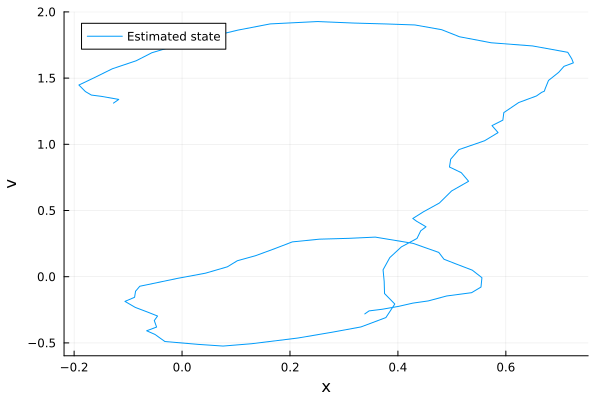

In [31]:
new_val = SSM.interleave_reshape(res.minimizer, 100, 2)

plot(new_val[:, 1], new_val[:, 2], label="Estimated state", xlabel="x", ylabel="v", legend=:topleft)

In [33]:
maximum(SSM.Gradient(lds, y, new_val))

9.214851104388799e-14